In [ ]:
import os, sys

# path to access c++ files
sys.path.append(os.getenv("HOME"))

In [2]:
from cunqa import getQPUs

qpus  = getQPUs()

for q in qpus:
    print(f"QPU {q.id}, backend: {q.backend.name}, simulator: {q.backend.simulator}, version: {q.backend.version}.")


QPU 0, backend: BasicAer, simulator: AerSimulator, version: 0.0.1.
QPU 1, backend: BasicAer, simulator: AerSimulator, version: 0.0.1.
QPU 2, backend: BasicAer, simulator: AerSimulator, version: 0.0.1.
QPU 3, backend: BasicAer, simulator: AerSimulator, version: 0.0.1.
QPU 4, backend: BasicAer, simulator: AerSimulator, version: 0.0.1.


# Examples for optimizations

Before sending a circuit to the QClient, a transpilation process occurs (if not, it is done by the user). This process, in some cases, can take much time and resources, in addition to the sending cost itself. If we were to execute a single circuit once, it shouldn´t be a big problem, but it is when it comes to variational algorithms.

This quantum-classical algorithms require several executions of the same circuit but changing the value of the parameters, which are optimized in the classical part. In order to optimize this, we developed a functionallity that allows the user to upgrade the circuit parameters with no extra transpilations of the circuit, sending to the `QClient` the list of the parameters **ONLY**. This is of much advantage to speed up the computation in the cases in which transpilation takes a significant part of the total time of the simulation.

Let´s see how to work with this feature taking as an example a _Variational Quantum Algorithm_ for state preparation.

We start from a _Hardware Efficient Ansatz_ to build our parametrized circuit:

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

def hardware_efficient_ansatz(num_qubits, num_layers):
    qc = QuantumCircuit(num_qubits)
    param_idx = 0
    for _ in range(num_layers):
        for qubit in range(num_qubits):
            phi = Parameter(f'phi_{param_idx}_{qubit}')
            lam = Parameter(f'lam_{param_idx}_{qubit}')
            qc.ry(phi, qubit)
            qc.rz(lam, qubit)
        param_idx += 1
        for qubit in range(num_qubits - 1):
            qc.cx(qubit, qubit + 1)
    qc.measure_all()
    return qc

The we need a cost function. We will define a target distribution and measure how far we are from it. We choose to prepare a normal distribution among all the $2^n$ possible outcomes of the circuit.

In [4]:
def target_distribution(num_qubits):
    # Define a normal distribution over the states
    num_states = 2 ** num_qubits
    states = np.arange(num_states)
    mean = num_states / 2
    std_dev = num_states / 4
    target_probs = norm.pdf(states, mean, std_dev)
    target_probs /= target_probs.sum()  # Normalize to make it a valid probability distribution
    target_dist = {format(i, f'0{num_qubits}b'): target_probs[i] for i in range(num_states)}
    return target_dist

import pandas as pd
from scipy.stats import entropy, norm

def KL_divergence(counts, n_shots, target_dist):
    # Convert counts to probabilities
    pdf = pd.DataFrame.from_dict(counts, orient="index").reset_index()
    pdf.rename(columns={"index": "state", 0: "counts"}, inplace=True)
    pdf["probability"] = pdf["counts"] / n_shots
    
    # Create a dictionary for the obtained distribution
    obtained_dist = pdf.set_index("state")["probability"].to_dict()
    
    # Ensure all states are present in the obtained distribution
    for state in target_dist:
        if state not in obtained_dist:
            obtained_dist[state] = 0.0
    
    # Convert distributions to lists for KL divergence calculation
    target_probs = [target_dist[state] for state in sorted(target_dist)]
    obtained_probs = [obtained_dist[state] for state in sorted(obtained_dist)]
    
    # Calculate KL divergence
    kl_divergence = entropy(obtained_probs, target_probs)
    
    return kl_divergence
    

In [5]:
num_qubits = 6

num_layers = 3

n_shots = 1e5

### Simply using the `QPU.run()` method

At first we should try the intiutive alternative: upgrading parameters at the QClient, transpiling and sending the whole circuit to the QPU.

In [6]:
def cost_function_run(params):
    n_shots = 1e5
    target_dist = target_distribution(num_qubits)
    
    circuit = ansatz.assign_parameters(params)
    
    result = qpu.run(circuit, transpile = True, opt_level = 0, shots = n_shots).result()
    
    counts = result.get_counts()
    
    return KL_divergence(counts, n_shots, target_dist)

Our cost function updates the parameters given by the optimizer, asigns them to the ansatz and sends the circuit with the transpilation option set `True`. Let´s choose a QPU to work with and go ahead with the optimization:

In [7]:
import numpy as np
import time

qpu = qpus[0]

In [8]:
ansatz = hardware_efficient_ansatz(num_qubits, num_layers)

num_parameters = ansatz.num_parameters

initial_parameters = np.zeros(num_parameters)

from scipy.optimize import minimize

i = 0

cost_run = []
individuals_run = []

def callback(xk):
    global i
    e = cost_function_run(xk)
    individuals_run.append(xk)
    cost_run.append(e)
    if i%20 == 0:
        print(f"Iteration step {i}: f(x) = {e}")
    i+=1

tick = time.time()
optimization_result_run = minimize(cost_function_run, initial_parameters, method='COBYLA',
        callback=callback, tol = 0.01,
        options={
        'disp': True,     # Print info at the end
        'maxiter': 4000   # Limit the number of iterations
    })
tack = time.time()
time_run = tack-tick
print()
print("Total optimization time: ", time_run, " s")
print()

Iteration step 0: f(x) = 5.644885693319627
Iteration step 20: f(x) = 3.2445195698171907
Iteration step 40: f(x) = 0.6966290427761286
Iteration step 60: f(x) = 0.5163598407043049
Iteration step 80: f(x) = 0.44852083459660524
Iteration step 100: f(x) = 0.38505451594736056
Iteration step 120: f(x) = 0.17479915421919842
Iteration step 140: f(x) = 0.1511853513109766
Iteration step 160: f(x) = 0.13348275797727643
Iteration step 180: f(x) = 0.11725829882821526
Iteration step 200: f(x) = 0.09629509929195565
Iteration step 220: f(x) = 0.09371148655873274
Iteration step 240: f(x) = 0.08307941565006814
Iteration step 260: f(x) = 0.08037262815685492
Iteration step 280: f(x) = 0.07056386232882396
Iteration step 300: f(x) = 0.06440830643687238
Iteration step 320: f(x) = 0.056024271864987436
Iteration step 340: f(x) = 0.051716060968955695
Iteration step 360: f(x) = 0.04994929260411999
Iteration step 380: f(x) = 0.043279654006247587
Iteration step 400: f(x) = 0.04165219341000945
Iteration step 420: f(

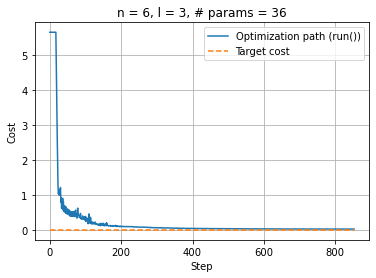

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.clf()
plt.plot(np.linspace(0, optimization_result_run.nfev, optimization_result_run.nfev), cost_run, label="Optimization path (run())")
upper_bound = optimization_result_run.nfev
plt.plot(np.linspace(0, upper_bound, upper_bound), np.zeros(upper_bound), "--", label="Target cost")
plt.xlabel("Step"); plt.ylabel("Cost"); plt.legend(loc="upper right"); plt.title(f"n = {num_qubits}, l = {num_layers}, # params = {num_parameters}")
plt.grid(True)
plt.show()
# plt.savefig(f"optimization_run_n_{num_qubits}_p_{num_parameters}.png", dpi=200)

### Using `QJob.upgrade_parameters()`

The first step now is to create the `qjob.QJob` object that which parameters we are going to upgrade in each step of the optimization; for that, we must run a circuit with initial parameters in a QPU, the procedure is as we explained above:

In [10]:
ansatz = hardware_efficient_ansatz(num_qubits, num_layers)

num_parameters = ansatz.num_parameters

initial_parameters = np.zeros(num_parameters)

circuit = ansatz.assign_parameters(initial_parameters)

qjob = qpu.run(circuit, transpile = True, opt_level = 0, shots = n_shots)

Now that we have sent to the virtual QPU the transpiled circuit, we can use the method `qjob.QJob.upgrade_parameters()` to change the rotations of the gates:

In [11]:
print("Result with initial_parameters: ")
print(qjob.result().get_counts())

random_parameters = np.random.uniform(0, 2 * np.pi, num_parameters).tolist()
qjob.upgrade_parameters(random_parameters)

print()
print("Result with random_parameters: ")
print(qjob.result().get_counts())

Result with initial_parameters: 
{'000000': 100000}

Result with random_parameters: 
{'000000': 4991, '000001': 733, '010000': 1207, '010001': 966, '010010': 717, '010011': 4846, '010100': 303, '010101': 11928, '010110': 3464, '010111': 1300, '011000': 494, '011001': 1767, '011010': 75, '011011': 87, '011100': 1705, '011101': 645, '011110': 114, '011111': 1587, '000010': 2473, '100000': 3741, '100001': 251, '100010': 1330, '100011': 305, '100100': 74, '100101': 1010, '100110': 62, '100111': 484, '101000': 4464, '101001': 894, '101010': 6530, '101011': 1612, '101100': 615, '101101': 1137, '101110': 117, '101111': 5168, '000011': 803, '110000': 132, '110001': 184, '110010': 322, '110011': 1306, '110100': 60, '110101': 1098, '110110': 287, '110111': 135, '111000': 2673, '111001': 7841, '111010': 378, '111011': 393, '111100': 2894, '111101': 472, '111110': 170, '111111': 3048, '000100': 214, '000101': 4464, '000110': 339, '000111': 2031, '001000': 352, '001001': 42, '001010': 572, '001011'

**Important considerations:**

- The method acepts parameters in a `list`, if you have a `numpy.array`, simply apply `.tolist()` to transform it.

- When sending the circuit and setting `transpile=True`, we should be carefull that the transpilation process doesn't condense gates and combine parameters, therefore, if the user wants `cunqa`to transpile, they must set `opt_level=0`.

Note that `qjob.QJob.upgrade_parameters()` is a non-blocking call, as it was `qpu.QPU.run()`.

Now that we are familiar with the procedure, we can design a cost funtion that takes a set of parameters, upgrades the `qjob.QJob`, gets the result and calculates the divergence from the desired distribution:

In [12]:
def cost_function(params):
    n_shots = 100000
    target_dist = target_distribution(num_qubits)
    
    result = qjob.upgrade_parameters(params.tolist()).result()
    
    counts = result.get_counts()
    
    return KL_divergence(counts, n_shots, target_dist)


Now we are ready to start our optimization. We will use `scipy.optimize` to minimize the divergence of our result distribution from the target one:

In [13]:
from scipy.optimize import minimize
import time

i = 0

initial_parameters = np.zeros(num_parameters)

cost = []
individuals = []

def callback(xk):
    global i
    e = cost_function(xk)
    individuals.append(xk)
    cost.append(e)
    if i%10 == 0:
        print(f"Iteration step {i}: f(x) = {e}")
    i+=1

tick = time.time()
optimization_result = minimize(cost_function, initial_parameters, method='COBYLA',
        callback=callback, tol = 0.01,
        options={
        'disp': True,     # Print info during iterations
        'maxiter': 4000     # Limit the number of iterations
    })
tack = time.time()
time_up = tack-tick
print()
print("Total optimization time: ", time_up, " s")

Iteration step 0: f(x) = 4.80575155259839
Iteration step 10: f(x) = 2.970696095355457
Iteration step 20: f(x) = 1.4895029742719816
Iteration step 30: f(x) = 0.7682504360329634
Iteration step 40: f(x) = 0.6136147280902352
Iteration step 50: f(x) = 0.5050298801455128
Iteration step 60: f(x) = 0.42322370261946995
Iteration step 70: f(x) = 0.4921064893896492
Iteration step 80: f(x) = 0.43834989707739025
Iteration step 90: f(x) = 0.35972438627667014
Iteration step 100: f(x) = 0.18442798997495824
Iteration step 110: f(x) = 0.11190454555348284
Iteration step 120: f(x) = 0.09816158141688647
Iteration step 130: f(x) = 0.10854489710323317
Iteration step 140: f(x) = 0.08408709754512673
Iteration step 150: f(x) = 0.06278778790384507
Iteration step 160: f(x) = 0.055076771396215814
Iteration step 170: f(x) = 0.061488076452479716
Iteration step 180: f(x) = 0.06198163653722114
Iteration step 190: f(x) = 0.04581740668492353
Iteration step 200: f(x) = 0.04035067690695984
Iteration step 210: f(x) = 0.033

We can plot the evolution of the cost function during the optimization:

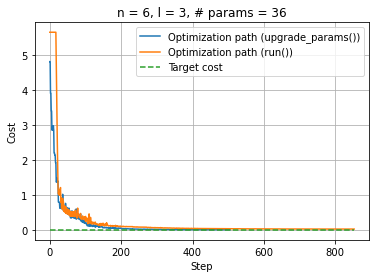

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.clf()
plt.plot(np.linspace(0, optimization_result.nfev, optimization_result.nfev), cost, label="Optimization path (upgrade_params())")
plt.plot(np.linspace(0, optimization_result_run.nfev, optimization_result_run.nfev), cost_run, label="Optimization path (run())")
upper_bound = max(optimization_result_run.nfev, optimization_result.nfev)
plt.plot(np.linspace(0, upper_bound, upper_bound), np.zeros(upper_bound), "--", label="Target cost")
plt.xlabel("Step"); plt.ylabel("Cost"); plt.legend(loc="upper right"); plt.title(f"n = {num_qubits}, l = {num_layers}, # params = {num_parameters}")
plt.grid(True)
plt.show()
# plt.savefig(f"optimization_n_{num_qubits}_p_{num_parameters}.png", dpi=200)